# Proposing/implementing some other perturbations for LIME

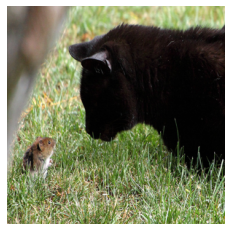

In [1]:
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from matplotlib import pyplot as plt

#Grabbing cat/mouse image from the Keras example notebook

url = 'https://github.com/marcotcr/lime/blob/master/doc/notebooks/data/cat_mouse.jpg?raw=true'
response = requests.get(url)
image = Image.open(BytesIO(response.content))
image = np.array(image.resize((299,299)))
perturbed_image = image.copy()

def show(im):
    plt.figure(facecolor='white')
    plt.imshow(im)
    plt.axis('off')

show(image)

In [2]:
#Segment the image with default parameters like in the notebook
from skimage.segmentation import quickshift
segments = quickshift(image, kernel_size=4, max_dist=200, ratio=0.2, random_seed=42)

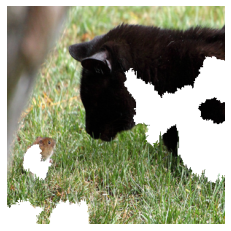

In [3]:
#Let's generate perturbations. Within LIME this would be done randomly.
#Here we will choose two large super pixels that are easy to see

superpixels = [25,35, 50, 51]

#We will apply the perturbations to it as a visualization.
#First, the ones we already use in LIME

#Solid Color:
hide_color = 255
fudged_image = image.copy()
fudged_image[:] = hide_color

#Apply to chosen segments
for superpixel in superpixels:
    perturbed_image[segments == superpixel] = fudged_image[segments == superpixel]

show(perturbed_image)

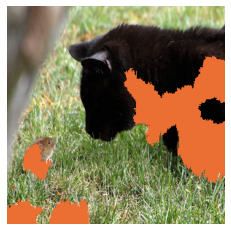

In [4]:
#This also works for [R,G,B] triples:
hide_color = [235,110,50]
fudged_image = image.copy()
fudged_image[:] = hide_color

#Apply to chosen segments
for superpixel in superpixels:
    perturbed_image[segments == superpixel] = fudged_image[segments == superpixel]

show(perturbed_image)

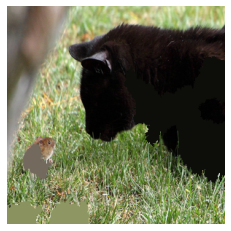

In [5]:
#If hide_color = None, it will return the average of the superpixel:
fudged_image = image.copy()
for x in np.unique(segments):
    fudged_image[segments == x] = (
        np.mean(image[segments == x][:, 0]),
        np.mean(image[segments == x][:, 1]),
        np.mean(image[segments == x][:, 2]))

#Apply to chosen segments
for superpixel in superpixels:
    perturbed_image[segments == superpixel] = fudged_image[segments == superpixel]
    
show(perturbed_image)

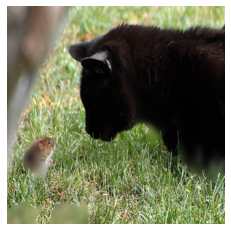

In [6]:
#Let's try a Gaussian blur
from skimage.filters import gaussian


fudged_image = image.copy()
fudged_image = gaussian(fudged_image, sigma=4, multichannel=True, preserve_range = True)

#Apply to chosen segments
for superpixel in superpixels:
    perturbed_image[segments == superpixel] = fudged_image[segments == superpixel]
    
show(perturbed_image)

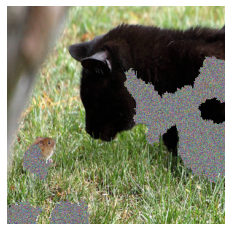

In [7]:
#We can also generate random noise

fudged_image = image.copy()
fudged_image = np.random.normal(255/2,255/9,size = fudged_image.shape).astype('int')

#Apply to chosen segments
for superpixel in superpixels:
    perturbed_image[segments == superpixel] = fudged_image[segments == superpixel]
    
show(perturbed_image)

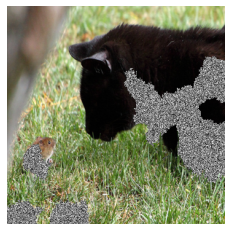

In [8]:
#Or black and white random noise

fudged_image = image.copy()
fudged_image = np.random.normal(255/2,255/5,size = (fudged_image.shape[:2])).astype('int')
fudged_image = np.stack((fudged_image,)*3, axis=-1)

#Apply to chosen segments
for superpixel in superpixels:
    perturbed_image[segments == superpixel] = fudged_image[segments == superpixel]
    
show(perturbed_image)

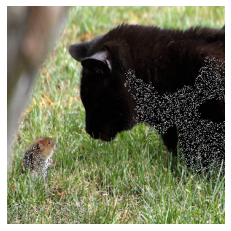

In [9]:
#We can also only add some noise on top of the original

fudged_image = image.copy()

percentage = 0.3 #Percentage of the Fudged Image that will be noise

dims = int(fudged_image.size/3) #Number of pixels in the image
halfdim = np.ceil(percentage*(dims)).astype(int)
mask = np.hstack((np.zeros(dims-halfdim),np.ones(halfdim))) #This mask determines which pixels become noise

#Let's borrow our black and white noise from above. But any other type of perturbation could be used here
noise = np.random.normal(255/2,255/5,size = (fudged_image.shape[:2])).astype('int')
noise = np.stack((noise,)*3, axis=-1)

np.random.shuffle(mask) #Randomize the mask
mask = mask.reshape(fudged_image.shape[:2]).astype('bool') #Reshape the mask to the same shape as the image

fudged_image[mask] = noise[mask]

#Apply to chosen segments
for superpixel in superpixels:
    perturbed_image[segments == superpixel] = fudged_image[segments == superpixel]
    
show(perturbed_image)